# Confidence Comparing

The idea here is that we want to compare probabilities of predicted image classes across models and the augmentations of those models. If we can say that the models are really thinking differently in terms of the probabilities they are assigning, this might have implications for understanding manipulations we can make to address the distribution gap

In [1]:
!pip install upsetplot

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


In [27]:
from ast import literal_eval
import os
import pandas as pd
from glob import glob
import numpy as np
from sklearn.metrics import classification_report
import torchvision
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
import matplotlib.pyplot as plt
from upsetplot import plot 
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

In [28]:
# Retrieve the official labels of the CIFAR10 test dataset
testset = torchvision.datasets.CIFAR10(root='../../data/cifar10/', train=False,
                                       download=True)
test_labels_CIFAR10 = testset.targets
test_data_CIFAR10 = testset.data

# Retrieve the official labels of the CIFAR10.1 test dataset
test_labels_CIFAR101 =np.load('../data/cifar101/cifar10.1_v6_labels.npy')  
test_data_CIFAR101 = np.load('../data/cifar101/cifar10.1_v6_data.npy')

# Create a dictionary that maps numeric class number to class name
class_dict = {0: "airplane",
              1: "automobile",
              2: "bird",
              3: "cat",
              4: "deer",
              5: "dog",
              6: "frog",
              7: "horse",
              8: "ship",
              9: "truck"
}

classes = ['0 airplane', '1 automobile', '2 bird', '3 cat', '4  deer', '5 dog', '6 frog', 
           '7 horse', '8 ship', '9 truck']

# Confirm that when we compare these labels to our guesses, we get the accuracy score.
def confirm_score(zfile, test_labels):
    print("\nAccuracy:", zfile['acc'])
    print(" -> Sanity Check:", np.sum(test_labels_CIFAR10 == zfile['labels']), "of", 
          len(test_labels), "correct\n")
    
    # Examine the classes to see if the model is balanced in its accuracy across all labels 
    report = classification_report(test_labels, zfile['labels'], target_names=classes, output_dict=True)
    print(pd.DataFrame(report).transpose())

Files already downloaded and verified


In [29]:
number_to_analyze = 20

def error_by_r_score(zfile, test_labels, testset):
    images_to_print = []
    
    # Determine the probability we associatd with our predicted label
    pp_max = np.max(zfile['probs'], axis=1)

    # Retrieve the model's predicted probability of the correct label
    pp_correct = zfile['probs'][range(zfile['probs'].shape[0]), test_labels]

    # Calculate the R ratio for each document
    r = pp_max/pp_correct

    # Retrieve the row numbers where the R score is the highest
    max_r_value_indexes = r.argsort()

    # Create list to hold stats on highest R Score images
    stats = []
    
    for mi in max_r_value_indexes:
        #print("-- R Ratio:", r[mi], " ( index", mi, 
        #      ")\n   Guessed Label:", zfile['labels'][mi], class_dict[zfile['labels'][mi]], 
        #      "\n   Correct Label:", test_labels[mi], class_dict[test_labels[mi]],
        #      "\n   Class Probs:", zfile['probs'][mi], "\n")
        
        img_dict = {'prob_predicted': pp_max[mi],
                    'prob_correct': pp_correct[mi],
                    'r_value': r[mi],
                    'label_predicted_id': zfile['labels'][mi],
                    'label_predicted': class_dict[zfile['labels'][mi]],
                    'correct_label': test_labels[mi],
                    'correct_label_id': class_dict[test_labels[mi]],
                    'img_index': mi
                   }

        img=Image.fromarray(testset[mi])
        images_to_print.append(img)
        stats.append(img_dict)
        


#     # Print the misclassified images
#     fig = plt.figure(figsize=(16, 4))
#     grid = ImageGrid(fig, 111,  
#                      nrows_ncols=(2, 10),  
#                      axes_pad=0.1,  
#                      )

#     for ax, im in zip(grid, images_to_print):
#         # Iterating over the grid returns the Axes.
#         ax.imshow(im)
        
    return pd.DataFrame(stats)

In [30]:
output = '../model_results/densenet_BC_100_12/predictions_300.npz'
npzfile = np.load(output)
confirm_score(npzfile, test_labels_CIFAR10)


Accuracy: 0.9484
 -> Sanity Check: 9484 of 10000 correct

              precision  recall  f1-score     support
0 airplane     0.951244  0.9560  0.953616   1000.0000
1 automobile   0.971087  0.9740  0.972541   1000.0000
2 bird         0.955533  0.9240  0.939502   1000.0000
3 cat          0.899288  0.8840  0.891578   1000.0000
4  deer        0.937683  0.9630  0.950173   1000.0000
5 dog          0.898354  0.9280  0.912937   1000.0000
6 frog         0.966000  0.9660  0.966000   1000.0000
7 horse        0.983673  0.9640  0.973737   1000.0000
8 ship         0.954769  0.9710  0.962816   1000.0000
9 truck        0.968528  0.9540  0.961209   1000.0000
accuracy       0.948400  0.9484  0.948400      0.9484
macro avg      0.948616  0.9484  0.948411  10000.0000
weighted avg   0.948616  0.9484  0.948411  10000.0000


In [31]:
output = '../model_results/densenet_BC_100_12/predictions_300_CIFAR101.npz'
npzfile101 = np.load(output)
confirm_score(npzfile101, test_labels_CIFAR101)


Accuracy: 0.883
 -> Sanity Check: 0 of 2000 correct

              precision  recall  f1-score   support
0 airplane     0.859296   0.855  0.857143   200.000
1 automobile   0.968354   0.765  0.854749   200.000
2 bird         0.873171   0.895  0.883951   200.000
3 cat          0.851064   0.800  0.824742   200.000
4  deer        0.898551   0.930  0.914005   200.000
5 dog          0.864322   0.860  0.862155   200.000
6 frog         0.921182   0.935  0.928040   200.000
7 horse        0.939394   0.930  0.934673   200.000
8 ship         0.858491   0.910  0.883495   200.000
9 truck        0.822511   0.950  0.881671   200.000
accuracy       0.883000   0.883  0.883000     0.883
macro avg      0.885634   0.883  0.882462  2000.000
weighted avg   0.885634   0.883  0.882462  2000.000


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [32]:
df_densenet_errors  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

In [33]:
df_densenet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

In [34]:
def prob_histogram(errors_df, model, dataset):

    x1 = errors_df[errors_df['r_value'] == 1]['prob_predicted']
    x2 = errors_df[errors_df['r_value'] > 1]['prob_predicted']

    ax1 = sns.distplot(x1, hist = True, kde = False, bins = 10, label = "Classified Correct")
    ax2 = sns.distplot(x2, hist = True, kde = False, bins = 10, label = "Classified Incorrect")

    # get the highest value and then display it as text
    heights = []
    for p in ax1.patches:
        heights.append(p.get_height())

    ax1.text(0.935, 900, str(max(heights)), fontsize = 8)
    ax1.legend()
    # s = 0

    # for p in ax2.patches:
    #     s+= p.get_height()

    # for p in ax2.patches: 
    #     ax2.text(p.get_x() + p.get_width()/2.,
    #             p.get_height(),
    #             '{}'.format(int(p.get_height()*100/s)), 
    #             fontsize=14,
    #             color='red',
    #             ha='center',
    #             va='bottom')

    plt.title("Highest image probability (" + dataset + ") - " + model)
    plt.xlabel("Number of Observations")
    plt.ylim(0, 1000)
    plt.show()

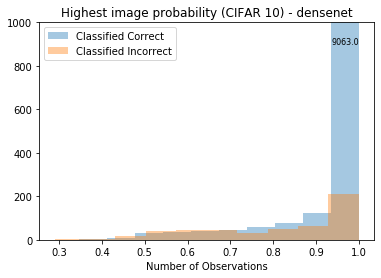

In [35]:
prob_histogram(df_densenet_errors, "densenet", "CIFAR 10")

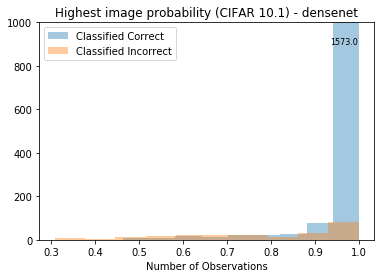

In [36]:
prob_histogram(df_densenet_errors_101, "densenet", "CIFAR 10.1")

In [37]:
# densenet ra(1,20)
output = '../model_results/densenet_BC_100_12_ra_1_20/predictions_400_refined50.npz'
npzfile = np.load(output)
df_densenet_errors  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

output = '../model_results/densenet_BC_100_12_ra_1_20/predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
df_densenet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

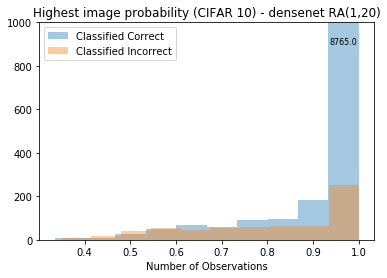

In [38]:
prob_histogram(df_densenet_errors, "densenet RA(1,20)", "CIFAR 10")

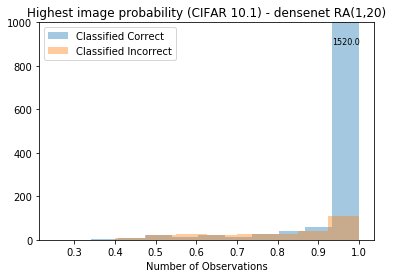

In [39]:
prob_histogram(df_densenet_errors_101, "densenet RA(1,20)", "CIFAR 10.1")

In [40]:
# densenet ra(2,5)
output = '../model_results/densenet_BC_100_12_ra_2_5/predictions_400_refined50.npz'
npzfile = np.load(output)
df_densenet_errors  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

output = '../model_results/densenet_BC_100_12_ra_2_5/predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
df_densenet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

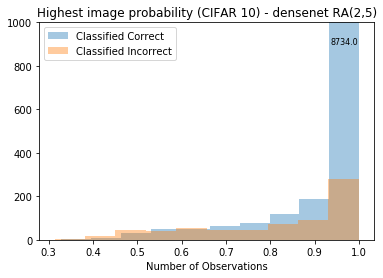

In [41]:
prob_histogram(df_densenet_errors, "densenet RA(2,5)", "CIFAR 10")

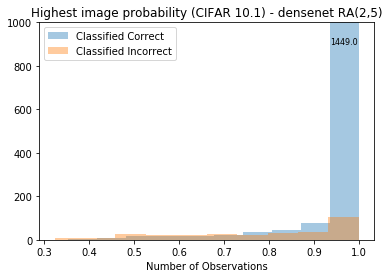

In [42]:
prob_histogram(df_densenet_errors_101, "densenet RA(2,5)", "CIFAR 10.1")

In [43]:
# densenet ra(2,20)
output = '../model_results/densenet_BC_100_12_ra_2_20/predictions_refined50.npz'
npzfile = np.load(output)
df_densenet_errors  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

output = '../model_results/densenet_BC_100_12_ra_2_20/predictions_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
df_densenet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

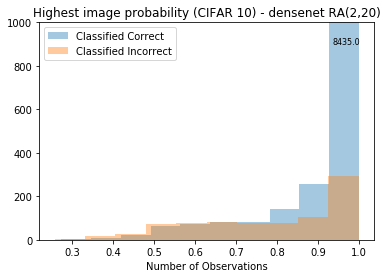

In [44]:
prob_histogram(df_densenet_errors, "densenet RA(2,20)", "CIFAR 10")

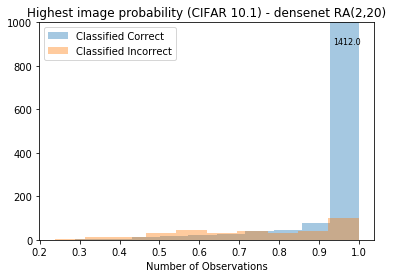

In [45]:
prob_histogram(df_densenet_errors_101, "densenet RA(2,20)", "CIFAR 10.1")

In [46]:
# densenet ra(3,20)
output = '../model_results/densenet_BC_100_12_ra_3_20/predictions_400_refined50.npz'
npzfile = np.load(output)
df_densenet_errors  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

output = '../model_results/densenet_BC_100_12_ra_3_20/predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
df_densenet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

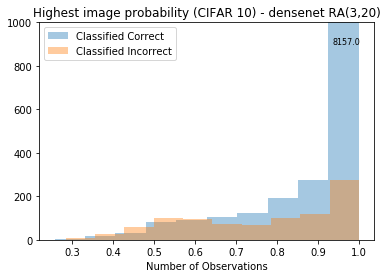

In [47]:
prob_histogram(df_densenet_errors, "densenet RA(3,20)", "CIFAR 10")

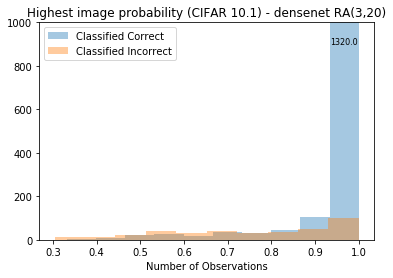

In [48]:
prob_histogram(df_densenet_errors_101, "densenet RA(3,20)", "CIFAR 10.1")

### resnet

In [49]:
# resnet basic
output = '../model_results/resnet_basic_32/predictions_160.npz'
npzfile = np.load(output)
df_resnet_errors  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

output = '../model_results/resnet_basic_32/predictions_160_CIFAR101.npz'
npzfile101 = np.load(output)
df_resnet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

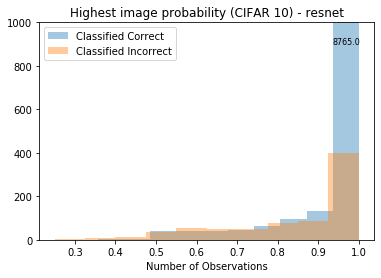

In [50]:
# plot cifar10
prob_histogram(df_resnet_errors, "resnet", "CIFAR 10")

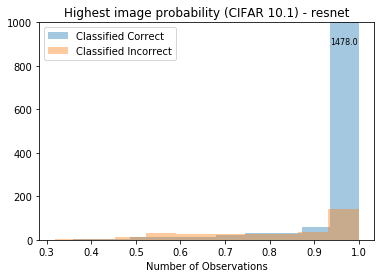

In [51]:
# plot cifar101
prob_histogram(df_resnet_errors_101, "resnet", "CIFAR 10.1")

In [54]:
# resnet RA(1,20)
output = '../model_results/resnet_basic_32_ra_1_20/predictions_refined50.npz'
npzfile = np.load(output)
df_resnet_errors  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

output = '../model_results/resnet_basic_32_ra_1_20/ predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
df_resnet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

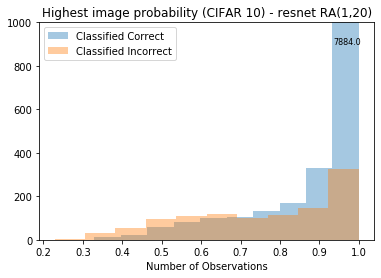

In [55]:
# plot cifar10
prob_histogram(df_resnet_errors, "resnet RA(1,20)", "CIFAR 10")

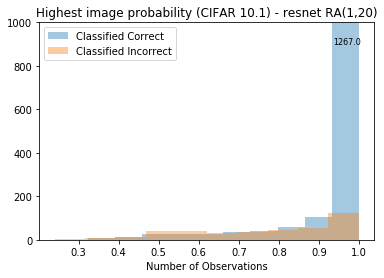

In [56]:
# plot cifar101
prob_histogram(df_resnet_errors_101, "resnet RA(1,20)", "CIFAR 10.1")

In [57]:
# resnet RA(2,5)
output = '../model_results/resnet_basic_32_ra_2_5/predictions_400_refined50.npz'
npzfile = np.load(output)
df_resnet_errors  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

output = '../model_results/resnet_basic_32_ra_2_5/predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
df_resnet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

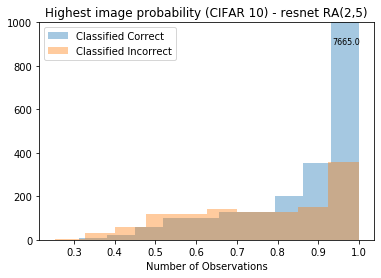

In [58]:
# plot cifar10
prob_histogram(df_resnet_errors, "resnet RA(2,5)", "CIFAR 10")

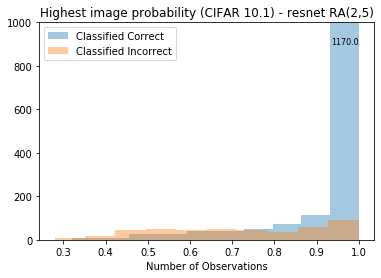

In [59]:
# plot cifar101
prob_histogram(df_resnet_errors_101, "resnet RA(2,5)", "CIFAR 10.1")

In [60]:
# resnet RA(2,20)
output = '../model_results/resnet_basic_32_ra_2_20/predictions_400_refined50.npz'
npzfile = np.load(output)
df_resnet_errors  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

output = '../model_results/resnet_basic_32_ra_2_20/predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
df_resnet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

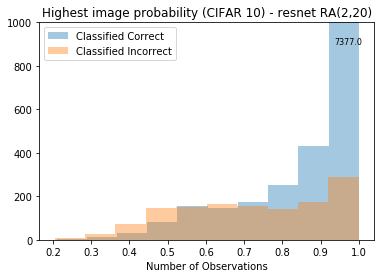

In [61]:
# plot cifar10
prob_histogram(df_resnet_errors, "resnet RA(2,20)", "CIFAR 10")

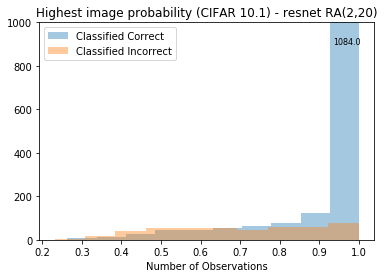

In [62]:
# plot cifar101
prob_histogram(df_resnet_errors_101, "resnet RA(2,20)", "CIFAR 10.1")

In [63]:
# resnet RA(3,20)

output = '../model_results/resnet_basic_32_ra_3_20/predictions_400_refined50.npz'
npzfile = np.load(output)
df_resnet_errors  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

output = '../model_results/resnet_basic_32_ra_3_20/predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
df_resnet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

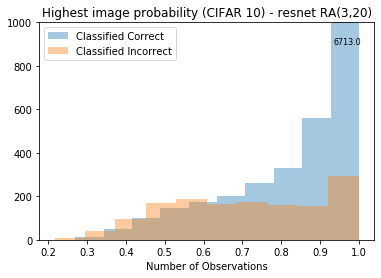

In [64]:
# plot cifar10
prob_histogram(df_resnet_errors, "resnet RA(3,20)", "CIFAR 10")

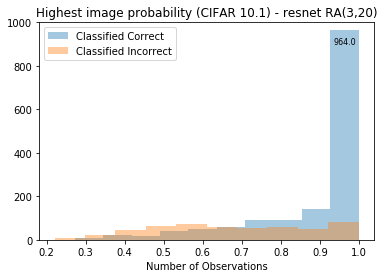

In [65]:
# plot cifar101
prob_histogram(df_resnet_errors_101, "resnet RA(3,20)", "CIFAR 10.1")

### resnext

In [66]:
# resnext basic
output = '../model_results/resnext_29_4x64/predictions_300.npz'
npzfile = np.load(output)
df_resnet_errors  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

output = '../model_results/resnext_29_4x64/predictions_300_CIFAR101.npz'
npzfile101 = np.load(output)
df_resnet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

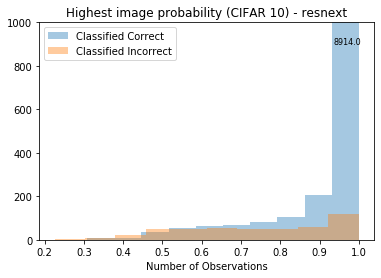

In [67]:
# plot cifar10
prob_histogram(df_resnet_errors, "resnext", "CIFAR 10")

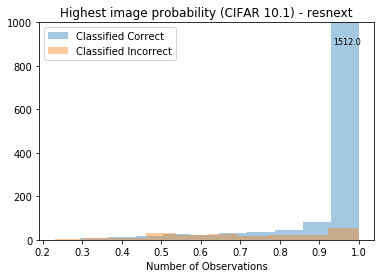

In [68]:
# plot cifar101
prob_histogram(df_resnet_errors_101, "resnext", "CIFAR 10.1")

In [74]:
# resnext ra(1,20)
output = '../model_results/resnext_29_4x64_ra_1_20/predictions_400_refined50.npz'
npzfile = np.load(output)
df_resnet_errors  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

output = '../model_results/resnext_29_4x64_ra_1_20/ predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
df_resnet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

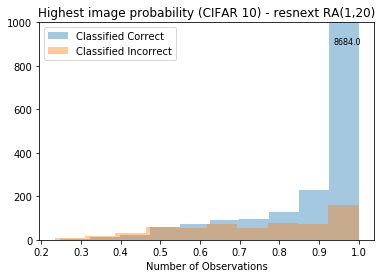

In [75]:
# plot cifar10
prob_histogram(df_resnet_errors, "resnext RA(1,20)", "CIFAR 10")

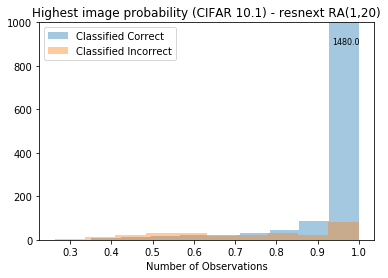

In [76]:
# plot cifar101
prob_histogram(df_resnet_errors_101, "resnext RA(1,20)", "CIFAR 10.1")

In [77]:
# resnext ra(2,5)
output = '../model_results/resnext_29_4x64d_ra_2_5/predictions_400_refined50.npz'
npzfile = np.load(output)
df_resnet_errors  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

output = '../model_results/resnext_29_4x64d_ra_2_5/predictions_400_refined50_cifar101.npz'
npzfile101 = np.load(output)
df_resnet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

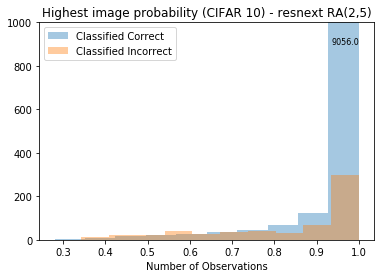

In [78]:
# plot cifar10
prob_histogram(df_resnet_errors, "resnext RA(2,5)", "CIFAR 10")

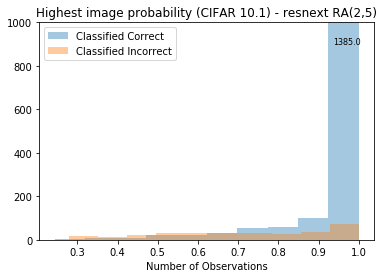

In [79]:
# plot cifar101
prob_histogram(df_resnet_errors_101, "resnext RA(2,5)", "CIFAR 10.1")

In [80]:
# resnext ra(2,20)
# w210-capstone/original_model_results/resnext_29_4x64_ra_2_20/ predictions_400_refined50.npz
output = '../model_results/resnext_29_4x64_ra_2_20/ predictions_400_refined50.npz'
npzfile = np.load(output)
df_resnet_errors  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

output = '../model_results/resnext_29_4x64_ra_2_20/ predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
df_resnet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

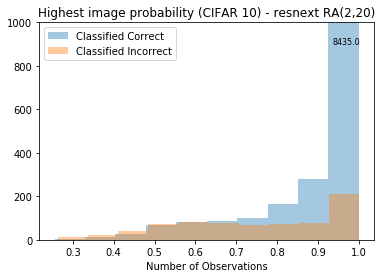

In [81]:
# plot cifar10
prob_histogram(df_resnet_errors, "resnext RA(2,20)", "CIFAR 10")

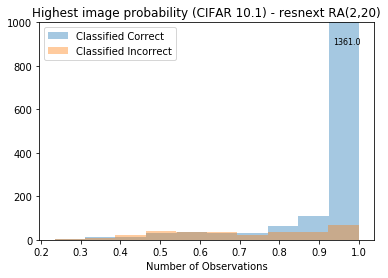

In [82]:
# plot cifar101
prob_histogram(df_resnet_errors_101, "resnext RA(2,20)", "CIFAR 10.1")

In [83]:
# resnext ra(3,20)
output = '../model_results/resnext_29_4x64_ra_3_20/ predictions_400_refined50.npz'
npzfile = np.load(output)
df_resnet_errors  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

output = '../model_results/resnext_29_4x64_ra_3_20/ predictions_400_refined50_cifar101.npz'
npzfile101 = np.load(output)
df_resnet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

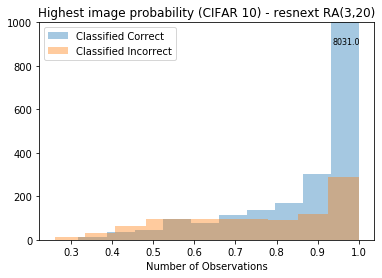

In [84]:
# plot cifar10
prob_histogram(df_resnet_errors, "resnext RA(3,20)", "CIFAR 10")

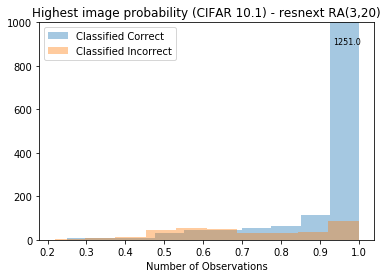

In [85]:
# plot cifar101
prob_histogram(df_resnet_errors_101, "resnext RA(3,20)", "CIFAR 10.1")

### wrn

In [86]:
# wrn basic
output = '../model_results/wrn_28_10/predictions_200.npz'
npzfile = np.load(output)
df_resnet_errors  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

output = '../model_results/wrn_28_10/predictions_200_CIFAR101.npz'
npzfile101 = np.load(output)
df_resnet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

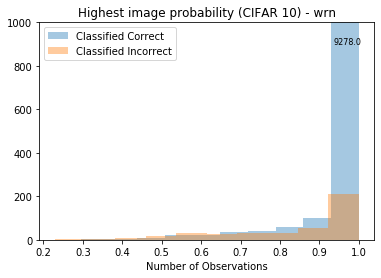

In [87]:
# plot cifar10
prob_histogram(df_resnet_errors, "wrn", "CIFAR 10")

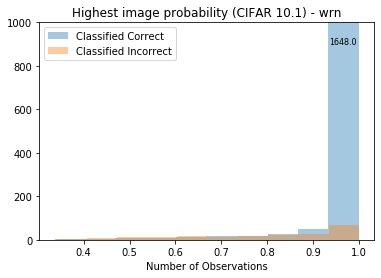

In [88]:
# plot cifar101
prob_histogram(df_resnet_errors_101, "wrn", "CIFAR 10.1")

In [90]:
# wrn ra(1,20)
output = '../model_results/wrn_28_10_ra_1_20/predictions_400_refined50.npz'
npzfile = np.load(output)
df_resnet_errors  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

output = '../model_results/wrn_28_10_ra_1_20/predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
df_resnet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

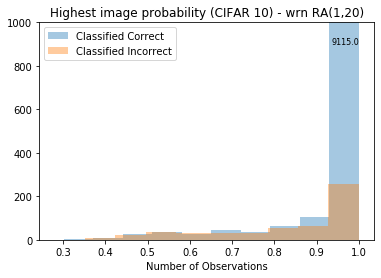

In [91]:
# plot cifar10
prob_histogram(df_resnet_errors, "wrn RA(1,20)", "CIFAR 10")

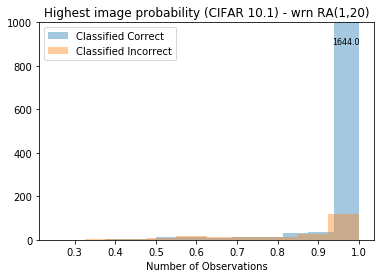

In [92]:
# plot cifar101
prob_histogram(df_resnet_errors_101, "wrn RA(1,20)", "CIFAR 10.1")

In [93]:
# wrn ra(2,5)
output = '../model_results/wrn_28_10_ra_2_5/predictions_400_refined50.npz'
npzfile = np.load(output)
df_resnet_errors  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

output = '../model_results/wrn_28_10_ra_2_5/predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
df_resnet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

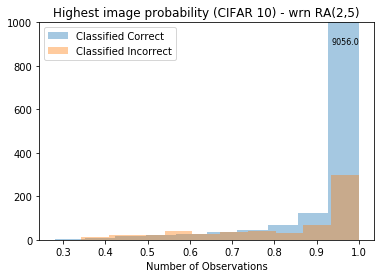

In [94]:
# plot cifar10
prob_histogram(df_resnet_errors, "wrn RA(2,5)", "CIFAR 10")

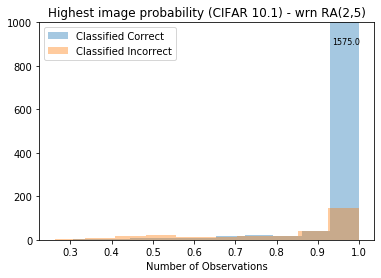

In [95]:
# plot cifar101
prob_histogram(df_resnet_errors_101, "wrn RA(2,5)", "CIFAR 10.1")

In [96]:
# wrn ra(2,20)
output = '../model_results/wrn_28_10_ra_2_20/predictions_refined50.npz'
npzfile = np.load(output)
df_resnet_errors  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

output = '../model_results/wrn_28_10_ra_2_20/predictions_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
df_resnet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

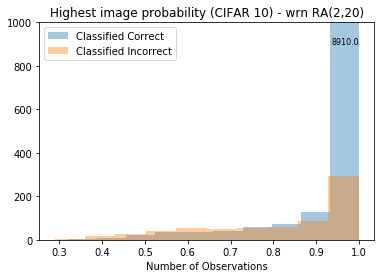

In [97]:
# plot cifar10
prob_histogram(df_resnet_errors, "wrn RA(2,20)", "CIFAR 10")

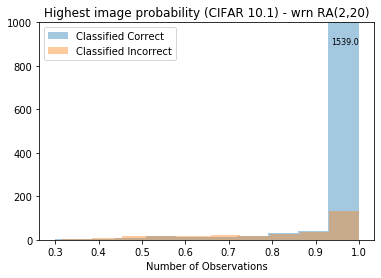

In [98]:
# plot cifar101
prob_histogram(df_resnet_errors_101, "wrn RA(2,20)", "CIFAR 10.1")

In [99]:
# wrn ra(3,20)
output = '../model_results/wrn_28_10_ra_3_20/predictions_400_refined50.npz'
npzfile = np.load(output)
df_resnet_errors  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

output = '../model_results/wrn_28_10_ra_3_20/predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
df_resnet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

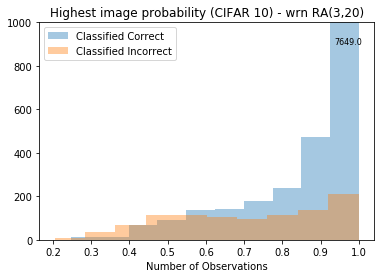

In [100]:
# plot cifar10
prob_histogram(df_resnet_errors, "wrn RA(3,20)", "CIFAR 10")

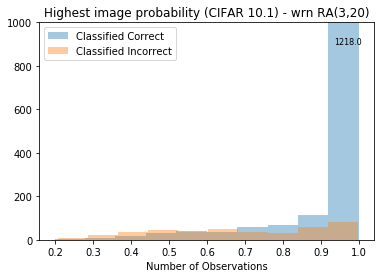

In [101]:
# plot cifar101
prob_histogram(df_resnet_errors_101, "wrn RA(3,20)", "CIFAR 10.1")